#**VOLCANOES ERUPTIONS DETECTION NETWORK**

## **WHAT IS A CNN?**

A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery. The name “convolutional neural network” indicates that the network employs a mathematical operation called **convolution**. Convolution is a specialized kind of linear operation. Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

# Google Drive connection to access the dataset
When executed it provides a **link to click** in order to get a temporary password (authorization code) to **fill the field**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Packages requirements

### Standard packages
Packages to do numerical computations, to use images, etc.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd

In [ ]:
!git clone https://github.com/ESA-PhiLab/ai4eo.git
!pip install -e /content/ai4eo/
!pip install rasterio shapely
!git clone https://github.com/atmtools/typhon.git
!pip install -e /content/typhon/

###Image preprocessing packages
Packages to do images manipulation such as resizing or to do **Image Augmentation**.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize

### Neural network packages
You both need to import the **type of model** you want to use (Sequential in our case) and the **layers** that will compose it.

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow.keras.backend as K
dtype='float16'
K.set_floatx(dtype)
# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4)

# Volcanoes eruption detection dataset 
### How the dataset has been created?
First of all we found a catalog containing all the information ragarding eruptions happened since 1999. 

In [ ]:
catalog = pd.read_csv('/content/drive/My Drive/volcanoes_detection/volcano_eruptions_from_1999_clean.csv')
catalog.head()

,start_time,Volcano Name,Latitude,Longitude
0,2019-06-26,Ulawun,-5.050,151.330
1,2019-06-24,Ubinas,-16.355,-70.903
2,2019-06-22,Raikoke,48.292,153.250
3,2019-06-11,"Fournaise, Piton de la",-21.244,55.708
4,2019-06-01,Great Sitkin,52.076,-176.130


The most important information is the **date**, in fact we discarded all the events happened before 2015 (when Sentinel 2 was launched). After that we created a **script that automatically dowloads** Sentinel 2 level 1-C products from **google earth engine platform**. The downloaded images are a cropped version of a "normal Sen2 image", in order to focus on volcanos we cut out a 10 by 10 km patch from the original image.  The last preprocessing step made is a **multispectral bands fusion** highlighting **infrared** information. An example of the final product is showed below.

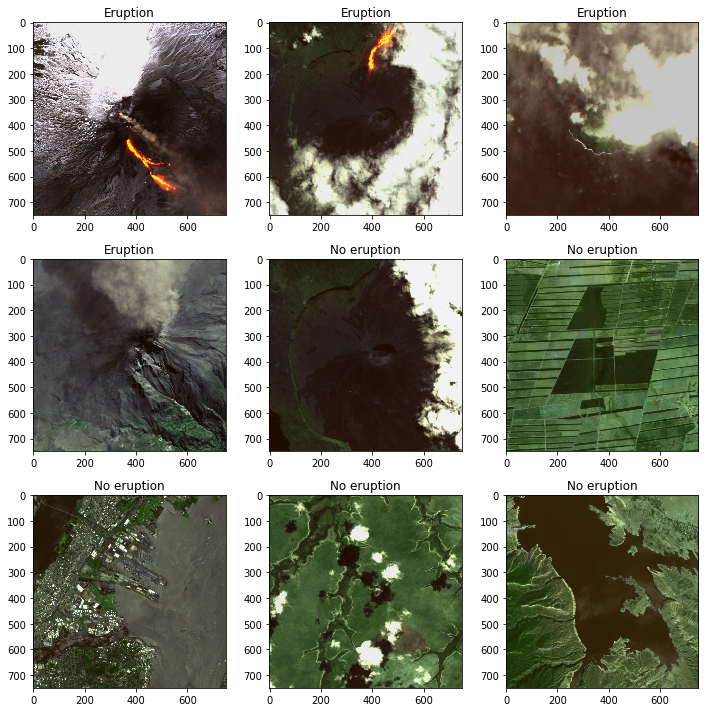

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(10,10))
images = []
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/validation_dataset/eruption/Etna-2018-20170319T095021_20170319T095021_T33SVB.png')) 
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/validation_dataset/eruption/Fournaise, Piton de la-2016-09-11-20160914T063512_20160914T095616_T40KCB.png'))
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/validation_dataset/eruption/Barren Island-2018-09-25-20180918T040541_20180918T040745_T46PEU.png'))
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/training_dataset/eruption/Ubinas-2017-20190624T145731_20190624T150226_T19KBB.png'))
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/training_dataset/no_eruption/Fournaise, Piton de la-2019-06-11-20180601T063509_20180601T063505_T40KCB.png'))              
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/training_dataset/no_eruption/Lat_-17.42105039_Lon_-62.27704286-2019-06-26-20180722T142039_20180722T142403_T20KNF.png'))              
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/training_dataset/no_eruption/NewYork-2019-06-26-20180630T154911_20180630T155933_T18TWL.png'))  
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/training_dataset/no_eruption/SerraGeralDoTocantinsEcologicalStation-2019-06-26-20180520T132241_20180520T132235_T23LLH.png'))
images.append(plt.imread('/content/drive/My Drive/volcanoes_detection/training_dataset/no_eruption/Lat_42.94272116_Lon_46.91295157-2019-06-26-20180626T074731_20180626T075138_T38TPN.png'))              

    
axes[0,0].imshow(images[0])
axes[0,0].set_title('Eruption')
axes[0,1].imshow(images[1])
axes[0,1].set_title('Eruption')
axes[0,2].imshow(images[2])
axes[0,2].set_title('Eruption')

axes[1,0].imshow(images[3])
axes[1,0].set_title('Eruption')
axes[1,1].imshow(images[4])
axes[1,1].set_title('No eruption')
axes[1,2].imshow(images[5])
axes[1,2].set_title('No eruption')

axes[2,0].imshow(images[6])
axes[2,0].set_title('No eruption')
axes[2,1].imshow(images[7])
axes[2,1].set_title('No eruption')
axes[2,2].imshow(images[8])
axes[2,2].set_title('No eruption')

fig.tight_layout()

### Dataset organization

- Master folder
  - Training folder
    - No eruption folder
    - Eruption folder
  - Validation folder
    - No eruption folder
    - Eruption folder
  - Testing folder
    - No eruption folder
    - Eruption folder
    
    
### Number of images
The dataset contains 1580 images in the training folder and 128 in the validation folder.

### **Images resizing and augmentation through Image Generator**


In [ ]:
def scale_image(image):
  resized = resize(image, (224,224), anti_aliasing=True, preserve_range=True)
  resized = 2.*resized/255.-1.
  return resized

Now the images are 224x224 pixels sized. They are smaller to reduce execution time but big enough to preserve features and patterns.

Now we can go on and do **Image Augmentation**.

Image Augmentation is a common technique in neural networks to increase the number of images in the dataset by applying particular changes on the available images. Common changes are image flipping and rotating, as well as brightness changing.

The Image Generator also helps in terms of **memory usage**.

In [ ]:
batch_size = 16
#train_path = '/content/drive/My Drive/volcanoes_detection/training_dataset'
#val_path = '/content/drive/My Drive/volcanoes_detection/validation_dataset'
train_path = '/content/drive/My Drive/volcanoes_detection/training_dataset_color_corr'
val_path = '/content/drive/My Drive/volcanoes_detection/validation_dataset_color_corr'
test_path = ' ' 
target_size = (224,224)

datagen = ImageDataGenerator(
    #rescale = 2./255,
    preprocessing_function = scale_image,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'reflect'
    
)

val_datagen = ImageDataGenerator(
    preprocessing_function = scale_image
)

Now we can create the input of the neural network by calling this function with these attributes:

*   path : the path where the dataset is
*   target size : the size
*   color mode : how we want to show the images
*   classes : the list of classes for our problem
*   class mode : the type of classes (in our case it is 'binary' because we have only two classes)
*   batch size : the number of images in each batch
*   shuffle : set to True to take random images


P.S.

The image labelling is made by splitting manually the images into different folders (called with the class name).

In [ ]:
ImageLoader?

In [ ]:
from ai4eo.preprocessing import ImageLoader

train_generator = ImageLoader(
    '/content/drive/My Drive/volcanoes_detection/training_dataset_color_corr/{label}/*.png', 
    batch_size=16, augmentator=datagen, balance=True, label_encoding='binary'
)
val_generator = ImageLoader(
    '/content/drive/My Drive/volcanoes_detection/validation_dataset_color_corr/{label}/*.png', 
    batch_size=16, augmentator=val_datagen, balance=True, label_encoding='binary'
)

train_generator_1 = datagen.flow_from_directory(
    train_path,
    target_size = target_size,
    color_mode = 'rgb',
    classes = ['no_eruption', 'eruption'],
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = True
)
  
# val_generator = val_datagen.flow_from_directory(
#     val_path,
#     target_size = target_size,
#     color_mode = 'rgb',
#     classes = ['no_eruption', 'eruption'],
#     class_mode = 'binary',
#     batch_size = batch_size,
#     shuffle = True
# )

# test_generator = test_datagen.flow_from_directory(
#     test_path,
#     target_size = target_size,
#     color_mode = 'rgb',
#     classes = ['no_eruption', 'eruption'],
#     class_mode = 'binary',
#     batch_size = batch_size,
#     shuffle = True
# )

Found 1742 images belonging to 2 classes.


In [ ]:
b, t = next(iter(train_generator))
b.shape

(16, 224, 224, 3)

# Proposed Network

### Constants
The model needs as **input** a vector with dimensions 224 x 224 x 3: 
* 224 x 224 is the size in pixels of each image
* 3 is the number of channels for an RGB image

Other important vector shapes to define are:
* the **kernel size** : the size of the filters used for the convolutional layers
* the **stride size** : the number of rows and columns with wich the filter moves
* the **pool size** : the dimension of the matrices to do the mean for the Pooling layers

In [ ]:
input_shape = (224,224,3)

kernel_size = (3,3)
stride_size = (1,1)
pool_size = (2,2)

### **Model definition**
Here you define how you want your network to be, how many and what type of layers you want to include.


In [ ]:
!ls -l '/content/drive/My Drive/volcanoes_detection/data_reviewed/validation/eruption' | wc -l

75


In [ ]:
!ls -l '/content/drive/My Drive/volcanoes_detection/data_reviewed/validation/no_eruption' | wc -l

94


In [ ]:
model = Sequential()

# model.add(Conv2D(128, kernel_size, strides=stride_size, padding='same', input_shape=input_shape))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Conv2D(64, kernel_size, strides=stride_size,input_shape=input_shape ))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(64, kernel_size, strides=stride_size))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size, strides=stride_size, padding='same', input_shape=input_shape))
model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Conv2D(64, kernel_size, strides=stride_size, padding='same'))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Conv2D(32, kernel_size, strides=stride_size))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
#model.add(Conv2D(32, kernel_size, strides=stride_size, padding='same'))
#model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size, strides=stride_size, padding='same'))
model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Conv2D(32, kernel_size, strides=stride_size, padding='same'))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Conv2D(16, kernel_size, strides=stride_size))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Conv2D(16, kernel_size, strides=stride_size, padding='same'))
model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Conv2D(16, kernel_size, strides=stride_size, padding='same'))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Conv2D(8, kernel_size, strides=stride_size))
# model.add(MaxPool2D(pool_size=pool_size, strides=stride_size))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Conv2D(8, kernel_size, strides=stride_size, padding='same'))
model.add(MaxPool2D(pool_size=pool_size, strides=stride_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


W0906 10:05:28.467117 140069832357760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### **Model Compiling**
Here you create your neural network and choose the **optimizer**, the **loss function** and the **metrics** to evaluate the performance.

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

W0906 10:05:34.736659 140069832357760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### **Summary**
Run to find out how your network looks like and to obtain the number of trainable and not trainable parameters.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      1

In [ ]:
#from tensorflow.keras.models import load_model
#big = load_model('/content/drive/My Drive/volcanoes_detection/json_model_score_0.87_color_corr/model_006.h5')

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras import callbacks as keras_callbacks

In [ ]:
class AdvancedMetrics(keras_callbacks.Callback):
  def __init__(self, val_data):
      super().__init__()
      self.validation_data = val_data
  def on_train_begin(self, logs={}):
      self.val_f1s = []
      self.val_recalls = []
      self.val_precisions = []
      
  def on_epoch_end(self, epoch, logs={}):
      b_predictions, b_targets = None, None
      # Go through all validation batches
      for b, batch in enumerate(self.validation_data):
        if b > len(self.validation_data):
          break
        inputs, targets = batch
        predictions = (self.model.predict_on_batch(inputs) > 0.5).astype(float)
        # The first time, there is no exising array to concatenate with
        if b_predictions is None:
          b_predictions = predictions
          b_targets = targets
        else:
          b_predictions = np.concatenate([b_predictions, predictions])
          b_targets = np.concatenate([b_targets, targets])
          
      _val_f1 = f1_score(b_targets, b_predictions, average='macro')
      _val_recall = recall_score(b_targets, b_predictions, average='macro')
      _val_precision = precision_score(b_targets, b_predictions, average='macro')
      
      self.val_f1s.append(_val_f1)
      self.val_recalls.append(_val_recall)
      self.val_precisions.append(_val_precision)
      print("\n val_f1: {:.3f} — val_precision: {:.3f} — val_recall {:.3f}".format(
         _val_f1, _val_precision, _val_recall
      ))
      return

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [ ]:
b, t = next(iter(train_generator))

In [ ]:
b.shape

(16,)

# Training 
Now you are ready to train your model! Make sure to set the **number of epochs** you want to use.

Other parameters to set are:
* the **number of steps per epoch** : the number of training images divided by the batch size
* the **number of validation steps** : the number of validation images divided by the batch size

In [ ]:
epochs = 120
steps_per_epoch = len(train_generator)
val_steps = len(val_generator)


init = time()

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=val_steps,
                              callbacks=[AdvancedMetrics(val_generator)],
                              use_multiprocessing = True,
                              workers = 12
                              )

elapsed_time = time() - init

Epoch 1/120


ValueError: ignored

How much time does the model take to be trained for N epochs?

In [ ]:
print('Elapsed time: %f seconds' % (elapsed_time))

# Plot of the model score
Here you can see the plots of accuracy and loss both on training and validation datasets.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].legend(['Training Accuracy', 'Validation Accuracy'])
axes[0].set_title('Training and Validation Accuracy', fontsize=20)
axes[0].set_xlabel('Epochs', fontsize=14)
axes[0].set_ylabel('Value', fontsize=14)

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['Training Loss', 'Validation Loss'])
axes[1].set_title('Training and Validation loss', fontsize=20)
axes[1].set_xlabel('Epochs', fontsize=14)
axes[1].set_ylabel('Value', fontsize=14)

fig.tight_layout()

If the model reaches interesting and good results you can use the function below to save it.

In [ ]:
model.save('/content/drive/My Drive/volcanoes_detection/model_9.h5')
model.to_json()
model.save_weights('/content/drive/My Drive/volcanoes_detection/model_weights_9.h5')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
def plot_confusion_matrix(
       y_true, y_pred, classes, normalize=False,
       title=None, cmap=plt.cm.Blues, ax=None):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting normalize=True.
  """
  if not title:
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  # Only use the labels that appear in the data
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  if ax is None:
      fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='True label',
         xlabel='Predicted label')
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
       for j in range(cm.shape[1]):
           ax.text(j, i, format(cm[i, j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
  return ax

b_predictions, b_targets = None, None
for b, batch in enumerate(val_generator):
    if b > len(val_generator):
        break
    inputs, targets = batch
    predictions = (model.predict_on_batch(inputs) > 0.5).astype(float)
    if b_predictions is None:
        b_predictions = predictions
        b_targets = targets
    else:
        b_predictions = np.concatenate([b_predictions, predictions])
        b_targets = np.concatenate([b_targets, targets])
results = {
    'predictions': b_predictions.tolist(),
    'targets': b_targets.tolist(),
}
classes = ['no_eruption', 'eruption']


print(classification_report(
    b_targets, b_predictions,
    target_names=classes
))

fig, axes = plt.subplots(ncols=2, figsize=(15, 7))
plot_confusion_matrix(
    results['targets'], results['predictions'], classes,
    ax=axes[0]
)
plot_confusion_matrix(
    results['targets'], results['predictions'], classes,
    ax=axes[1], normalize=True
)
fig.tight_layout()